In [21]:
import torch
import gym
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
env = gym.make('PongDeterministic-v4')
LEFT = 4
RIGHT = 5
print("List of available actions: ", env.unwrapped.get_action_meanings())


List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


## Preprocessing
* bkg_color variable is used to remove background

In [109]:
def preprocess_single(image, bkg_color = np.array([144, 72, 17])):
    img = np.mean(image[34:-16:2,::2]-bkg_color, axis=-1)/255.
    return img

def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)
    #return batch_input


### For testing if its working as planned 
* Croping the environment
* Skipping 1 pixels in between 
* subtract background images
* where we are skipping 1 pixed in resulting preprocessed image 

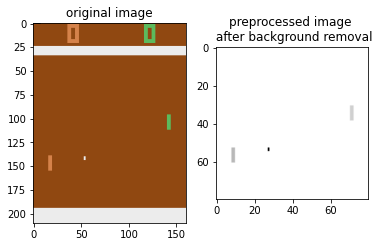

In [94]:
#this is for testing wheather it is working fine or not
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image \n after background removal')

# 80 x 80 black and white image
plt.imshow(preprocess_single(frame), cmap='Greys')
plt.show()


# Policy 

## Making Policy Update using Reinforce Policy Gradient

Here we define policy which takes input an image and output the probability of action. Here even though there are two actions ( Moving left and right), we only output single value $P_{\rm right}$. For left action we can use $P_{\rm left}$ = 1 - $P_{\rm right}$

### 1. Neural Network Architecture

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # conv1 : 80 x 80 -> 40 x 40
        self.conv1 = nn.Conv2d(2, 4, kernel_size=2, stride=2)
        # conv2 : 40 x 40 -> 20 x 20
        self.conv2 = nn.Conv2d(4, 8, kernel_size=2, stride=2)
        # conv3 : 20 x 20 -> 10 x 10
        self.conv3 = nn.Conv2d(8, 16, kernel_size=2, stride=2)
        # conv4 : 10 x 10 ->  5 x  5
        self.conv4 = nn.Conv2d(16, 32, kernel_size=2, stride=2)
        self.size = 32 * 5 * 5
        
        # 1 fully connected layer
        self.fc1 = nn.Linear(self.size, 64)
        self.fc2 = nn.Linear(64, 8)
        self.fc3 = nn.Linear(8, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = x.view(-1, self.size)
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = self.sig(self.fc3(x))
        return x

# use your own policy!
# policy=Policy().to(device)
policy=Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

#### Policy Network Summary

In [104]:
policy

Policy(
  (conv1): Conv2d(2, 4, kernel_size=(2, 2), stride=(2, 2))
  (conv2): Conv2d(4, 8, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv4): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (sig): Sigmoid()
)

### Testing at arbitary random actions 

In [107]:
import time
env = gym.make('PongDeterministic-v4')
state = env.reset()
while True:
    env.render()
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(0)
    state = next_state
    print('\rReward value {} '.format(reward), end=' ')
    if done:
        break
env.close()

Reward value -1.0  

### Testing Network without training 

In [114]:
import random
state = env.reset()
for _ in range(5):
    frame1, reward1, done, _ = env.step(np.random.choice([4,5]))
    frame2, reward2, done, _ = env.step(0)
if not done:
    for _ in range(2000):
        env.render()
        frame_input = preprocess_batch([frame1, frame2])
        prob = policy(frame_input)
        action = 4 if random.random() < prob else 5
        frame1, _, done, _ = env.step(action)
        if done:
            break

env.close()

### Creating Parallel Environment 

1. Instead of training throuh only one environement, we will use set of environment and use there action state value to train network
2. All these are done parallelly so that the cpu takes part in simulation and data collatection which is then shifted to gpu for further computation 
3. In single instance, it collects n instance of data which is then used to train
4. Doing Improvement in algorithm, involves normalising reward.
5. For this, we creates multiple instance of simulation whose values are then integrated using Pipe. Each simulation is actually different different process

In [121]:
from multiprocessing import Process, Pipe
from abc import ABC, abstractmethod

In [122]:
class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """
    def __init__(self, x):
        self.x = x

    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)

    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)

class VecEnv(ABC):
    """
    An abstract asynchronous, vectorized environment.
    """
    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    @abstractmethod
    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a dict of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    @abstractmethod
    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    @abstractmethod
    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a dict of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    @abstractmethod
    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        """
        Step the environments synchronously.
        This is available for backwards compatibility.
        """
        self.step_async(actions)
        return self.step_wait()

    def render(self, mode='human'):
        #logger.warn('Render not defined for %s' % self)
        pass
        
    @property
    def unwrapped(self):
        if isinstance(self, VecEnvWrapper):
            return self.venv.unwrapped
        else:
            return self

In [131]:
def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError


In [124]:
class parallelEnv(VecEnv):
    def __init__(self, env_name='PongDeterministic-v4',
                 n=4, seed=None,
                 spaces=None):

        env_fns = [ gym.make(env_name) for _ in range(n) ]

        if seed is not None:
            for i,e in enumerate(env_fns):
                e.seed(i+seed)
        
        """
        envs: list of gym environments to run in subprocesses
        adopted from openai baseline
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
        self.closed = True


### Collecting Trajectories from all the parallel Environment

In [125]:

# convert states to probability, passing through the policy
def states_to_prob(policy, states):
    states = torch.stack(states)
    policy_input = states.view(-1,*states.shape[-3:])
    return policy(policy_input).view(states.shape[:-3])

# return sum of log-prob divided by T
# same thing as -policy_loss
def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)

    ratio = new_probs/old_probs

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(ratio*rewards + beta*entropy)


In [126]:
def collect_trajectories(envs, policy, tmax=200, nrand=5):
    n=len(envs.ps)
    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]

    envs.reset()
    # start all parallel agents
    envs.step([1]*n)
    
    # perform nrand random steps
    for _ in range(nrand):
        fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT],n))
        fr2, re2, _, _ = envs.step([0]*n)
    
    for t in range(tmax):
        batch_input = preprocess_batch([fr1,fr2])
        probs = policy(batch_input).squeeze().cpu().detach().numpy()
        action = np.where(np.random.rand(n) < probs, RIGHT, LEFT)
        probs = np.where(action==RIGHT, probs, 1.0-probs)
        # advance the game (0=no action)
        # we take one action and skip game forward
        fr1, re1, is_done, _ = envs.step(action)
        fr2, re2, is_done, _ = envs.step([0]*n)

        reward = re1 + re2
        # store the result
        state_list.append(batch_input)
        reward_list.append(reward)
        prob_list.append(probs)
        action_list.append(action)
        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if is_done.any():
            break

    # return pi_theta, states, actions, rewards, probability
    return prob_list, state_list, \
        action_list, reward_list

####  Finally the training Part

In [135]:
episode = 40
discount_rate = .99
beta = .01
tmax = 100
sim_nos = 8

Episode: 20, score: -4.125000
[-4. -3. -4. -4. -5. -5. -4. -4.]


Episode: 40, score: -4.375000
[-5. -5. -5. -4. -5. -1. -5. -5.]


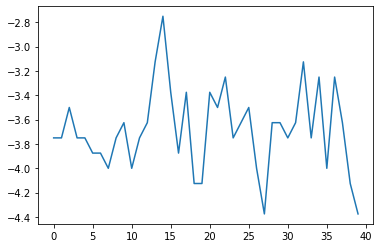

In [136]:
import progressbar as pb

widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()
#following generate sim_nos instance of simulation 
envs = parallelEnv('PongDeterministic-v4', n=sim_nos, seed=1234)
mean_rewards = []
for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
    collect_trajectories(envs, policy, tmax=tmax)  
    total_rewards = np.sum(rewards, axis=0)

    # this is the SOLUTION!
    # use your own surrogate function
    # L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
    L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
plt.plot(mean_rewards)
    

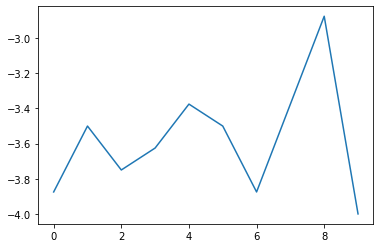